In [1]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
# import necessary packages

import os
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import ast

import seaborn as sns
from matplotlib import pyplot as plt

from collections import defaultdict

from sklearn.feature_selection import f_classif

In [2]:
DIR_WSI = "/Users/jinzhou/Desktop/USCAP/data/wsi"
DIR_ANN = "/Users/jinzhou/Desktop/USCAP/data/ann_geojsons"
DIR_SAVE = "/Users/jinzhou/Desktop/USCAP/data"

## Process thickness.csv

In [3]:
PATH_STAT = os.path.join(DIR_SAVE, "thickness.csv")

In [4]:
# read thickness analysis
def read_df_from_csv(path_csv):
    df = pd.read_csv(path_csv)
    # original list in path_csv is read as string, for example "[0.2, 0.1, ...]"
    # ast.literal_eval converts string to python literal structures
    df['Thickness_Media_Abs'] = df['Thickness_Media_Abs'].apply(lambda x: ast.literal_eval(x))
    df['Thickness_Intima_Abs'] = df['Thickness_Intima_Abs'].apply(lambda x: ast.literal_eval(x))
    df['Thickness_Wall_Abs'] = df['Thickness_Wall_Abs'].apply(lambda x: ast.literal_eval(x))
    return df

df_thick = read_df_from_csv(PATH_STAT)

In [5]:
# A few adjustment to match qupath annotations to labels assignment
# 1. In "11_26609_023_512 L4 TRI", A8 -> A08
# 2. In "11_26609_009_008 L10 TRI", there are two A26, where the second one should be A27
# 3. discard "12_26609_021_507 L03 TRI" from analysis

df_thick.loc[:, 'Artery_ID'] = df_thick.loc[:, 'Artery_ID'].str.split('_').str[0]

df_thick.loc[(df_thick.loc[:, 'WSI_ID'] == '11_26609_009_008 L10 TRI') & 
       (df_thick.loc[:, 'Artery_ID'] == 'A26'), 'Artery_ID'] = ['A26', 'A27']

df_thick.loc[(df_thick.loc[:, 'WSI_ID'] == '11_26609_023_512 L4 TRI') & 
       (df_thick.loc[:, 'Artery_ID'] == 'A8'), 'Artery_ID'] = 'A08'

df_thick = df_thick[df_thick.loc[:, "WSI_ID"]!="12_26609_021_507 L03 TRI"]

In [6]:
# Set and WSI_Artery_ID, ignoring media and intima index
df_thick.loc[:, 'WSI_Artery_ID'] = df_thick.loc[:, 'WSI_ID'] + '_' \
    + df_thick.loc[:, 'Artery_ID']

In [7]:
# For arteries with multiple lumen/intima areas, we pick the one with maxium lumen area
df_thick = df_thick.sort_values('Area', ascending=False).drop_duplicates(['WSI_Artery_ID'])

## Process "Labels.xlsx"

In [8]:
PATH_LABEL = "/Users/jinzhou/Desktop/USCAP/data/raw/labels_updated.xlsx"

In [9]:
df_label = pd.ExcelFile(PATH_LABEL)

# Only read the first sheet of the excel file
sheet_name = df_label.sheet_names[0]
df_label = df_label.parse(sheet_name, skiprows=1) # skip the first row
# Use Artery_ID as row index and WSI_ID as column name
df_label = df_label.rename(columns = {'Unnamed: 0':'Artery_ID'}).set_index("Artery_ID")

In [10]:
# replace labels of strings to integers.
df_label = df_label.replace({"without arteriosclerosis": 0, 
                             "mild arteriosclerosis": 1, 
                             "mild hyalinosis": 1, 
                             "moderate arteriosclerosis": 2,
                             "severe arteriosclerosis": 3, 
                             "-": np.nan, " - ": np.nan})


## Clip and Normalize Thickness

In [36]:
def plot_hist_w_two_list(thickness_outer, thickness_inner, xlabel, excludes, path_to_svae):
    for val in excludes:
        thickness_outer = [x for x in thickness_outer if x!=val]
        thickness_inner = [x for x in thickness_inner if x!=val]
    bins = np.linspace(0, np.max(thickness_outer+thickness_inner), 100)
    plt.figure(figsize=(10, 5))    
    plt.hist(thickness_outer, bins=bins, alpha=0.5, label="Media") 
    plt.hist(thickness_inner, bins=bins, alpha=0.5, label="Intima")
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel(xlabel, fontsize=20)
    plt.ylabel("Frequency", fontsize=20)
    plt.legend(loc='upper right', fontsize=20)
    if path_to_svae:
        plt.savefig(path_to_svae)
    plt.show()
    

def clip_normalize(thick_media, thick_intima, thick_wall, plot_hist=False):
    assert len(thick_media) == len(thick_intima) == len(thick_wall) == 360
    
    # visualize hist before processing
    if plot_hist:
        plot_hist_w_two_list(thick_media, thick_intima, "Thickness", [-1], None)
    # Clip by 0.05 * median value of  thick_wall
    # remove all -1s, -1 means not intersection/thickness was found at this sample    
    clip_th = 0.05*np.median([x for x in thick_wall if x!= -1])
    thick_media_norm = [-1]*len(thick_media)
    thick_intima_norm = [-1]*len(thick_intima)
    for i in range(len(thick_wall)):
        if thick_media[i] < clip_th or thick_intima[i] < clip_th: 
            # if either media or intima thickness is below threshold, discard both
            continue
        else:
            thick_media_norm[i] = thick_media[i] / thick_wall[i]
            thick_intima_norm[i] = thick_intima[i] / thick_wall[i]
    thick_media_norm = [x for x in thick_media_norm if x!=-1]
    thick_intima_norm = [x for x in thick_intima_norm if x!=-1]
    if plot_hist:
        plot_hist_w_two_list(thick_media_norm, thick_intima_norm, 
                             "Clipped and Normalizied Thickness", [], plot_hist)
    return thick_media_norm, thick_intima_norm

def get_features(dict_features, l_thick, prefix): 
    arr_thick = np.array(sorted(l_thick, reverse=True))
    # average of the top 5% value
    dict_features[prefix+" Average of Top 5%"] = np.mean(arr_thick[:len(arr_thick)//20])
    dict_features[prefix+" Skewness"] = scipy.stats.skew(arr_thick)
    dict_features[prefix+" Power"] = scipy.sum(arr_thick**2)/arr_thick.size

In [37]:
df_features_label = pd.DataFrame(columns = ["WSI_Artery_ID", "Media Average of Top 5%", "Media Skewness", "Media Power", 
                                             "Intima Average of Top 5%", "Intima Skewness", "Intima Power",
                                             "Label"])

for index, row in df_thick.iterrows():
    thick_media = row["Thickness_Media_Abs"]
    thick_intima = row["Thickness_Intima_Abs"]
    thick_wall = row["Thickness_Wall_Abs"]
    path_save_hist = os.path.join(DIR_SAVE, row["WSI_ID"], row["Artery_ID"]+"_hist.png")
    
    # clip and normalize
    thick_media, thick_intima = clip_normalize(thick_media = row["Thickness_Media_Abs"], 
                                               thick_intima = row["Thickness_Intima_Abs"], 
                                               thick_wall = row["Thickness_Wall_Abs"], plot_hist=None)
    # feature extraction
    row_features_label = {}
    features_media = get_features(row_features_label, thick_media, "Media")
    features_intima = get_features(row_features_label, thick_intima, "Intima")
    row_features_label["WSI_Artery_ID"] = row["WSI_Artery_ID"]
    row_features_label["Label"] = df_label.loc[row["Artery_ID"], row["WSI_ID"]]
    df_features_label = df_features_label.append(row_features_label, ignore_index=True)

In [38]:
df_features_label.head()

,WSI_Artery_ID,Media Average of Top 5%,Media Skewness,Media Power,Intima Average of Top 5%,Intima Skewness,Intima Power,Label
0,11_26609_023_512 L4 TRI_A15,0.944890,-0.735264,0.476863,0.794501,0.735264,0.153233,1.0
1,11_26609_000_013_L02 TRI_A06,0.598438,0.617807,0.116973,0.883658,-0.617807,0.466776,3.0
2,11_26609_023_512 L4 TRI_A06,0.774866,-1.437071,0.328156,0.950179,1.437071,0.245378,1.0
3,14_26609_040_021 L03 TRI_A01,0.691044,-0.280485,0.218889,0.881055,0.280485,0.350422,3.0
4,11_26609_027_005 L03 TRI_A08,0.870605,-1.066079,0.486147,0.664824,1.066079,0.115666,2.0


## HeatMap, Boxtplot and Kendall Tau Analysis

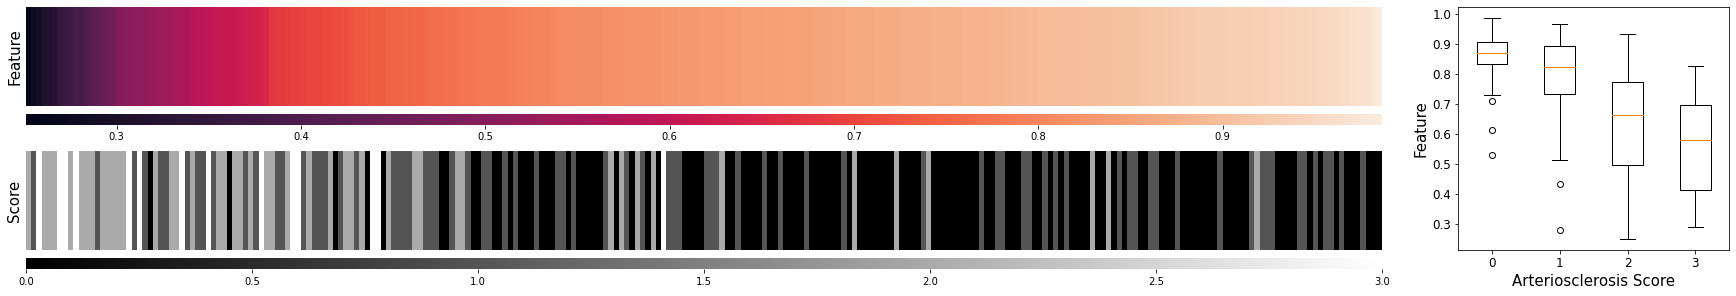

Feature: Media Average of Top 5%; kendalltau: rho = -0.43, p = 0.000000


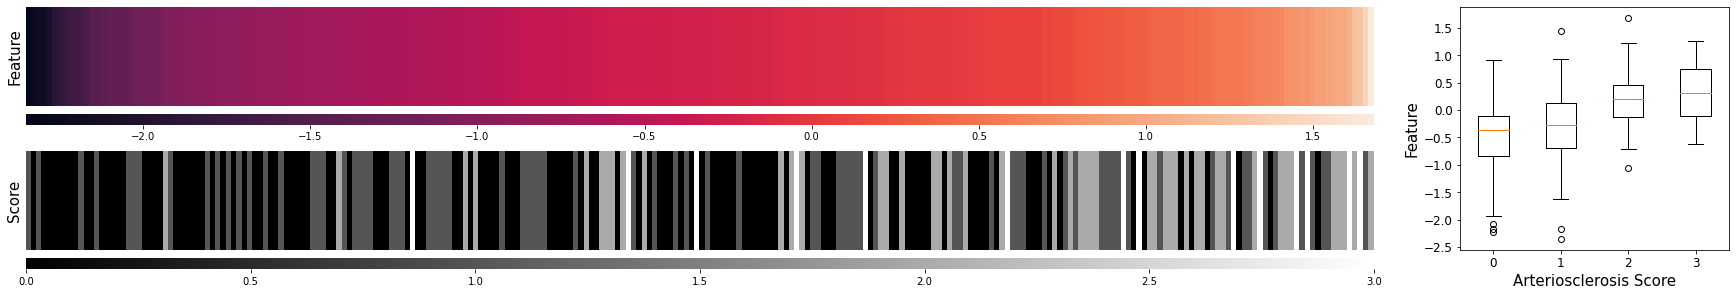

Feature: Media Skewness; kendalltau: rho = 0.32, p = 0.000000


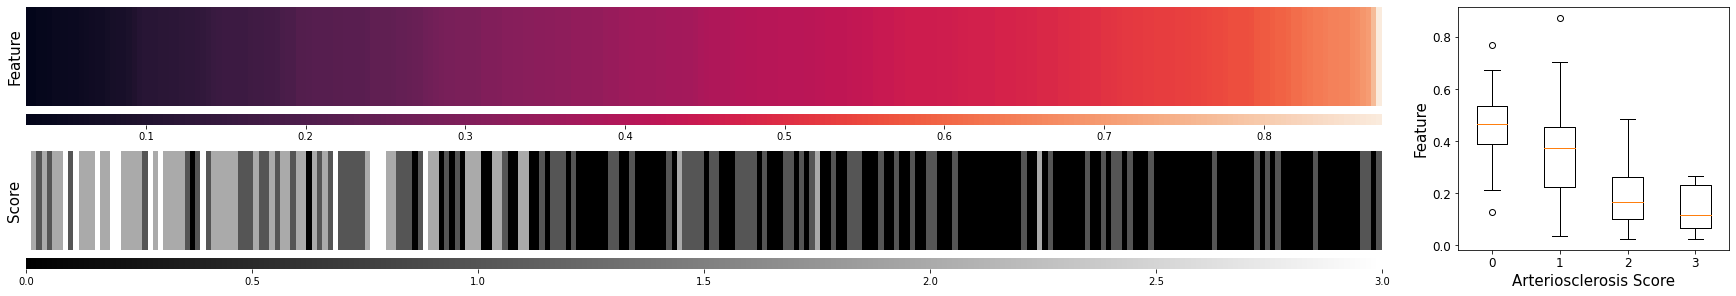

Feature: Media Power; kendalltau: rho = -0.52, p = 0.000000


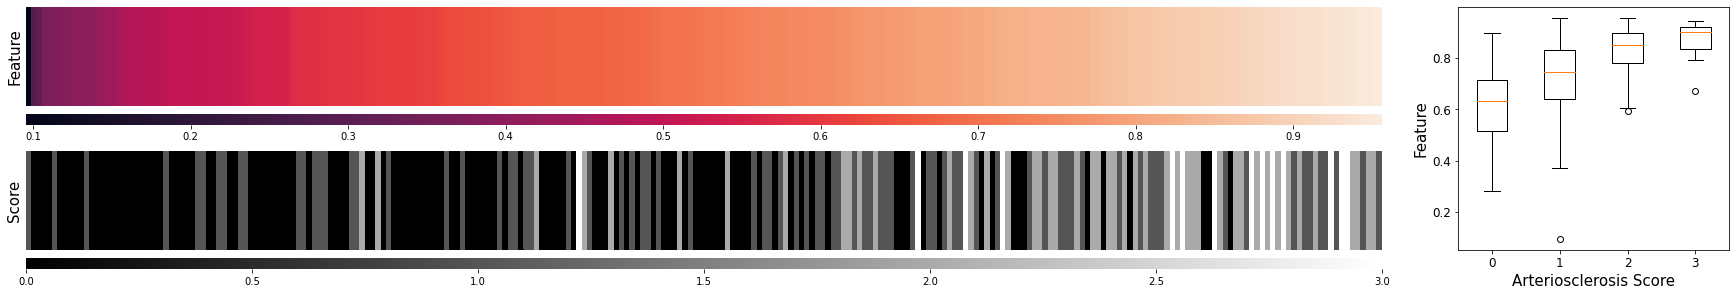

Feature: Intima Average of Top 5%; kendalltau: rho = 0.46, p = 0.000000


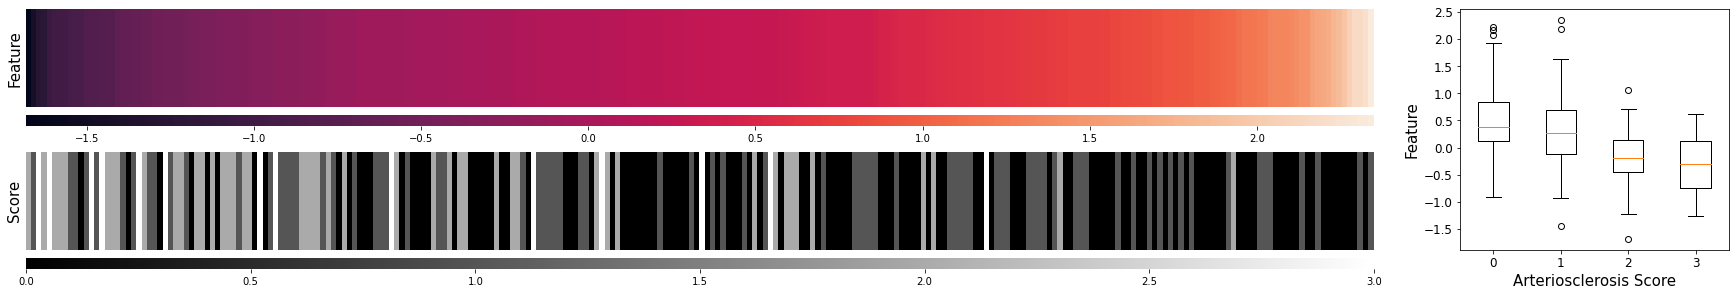

Feature: Intima Skewness; kendalltau: rho = -0.32, p = 0.000000


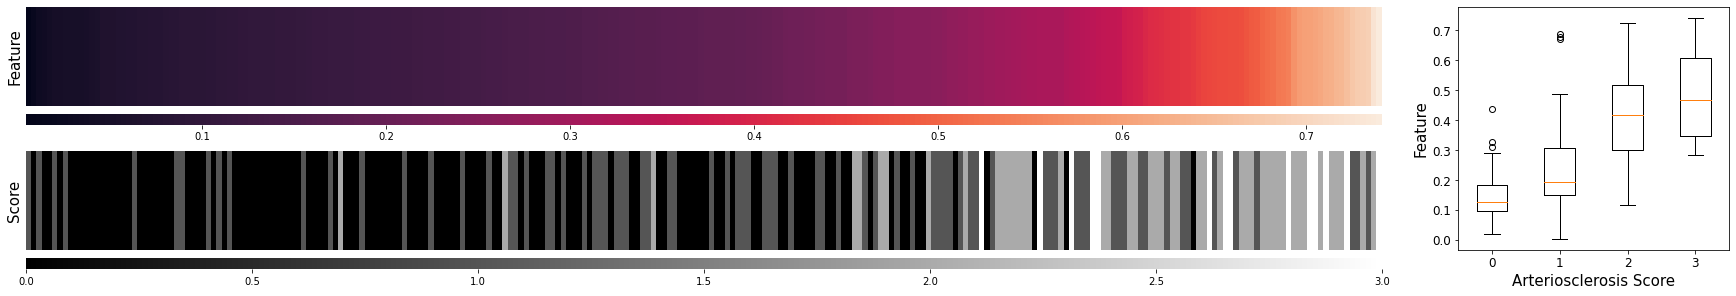

Feature: Intima Power; kendalltau: rho = 0.53, p = 0.000000


In [39]:
def heatmap_features(df_features_label, feature_name):
    xticklabels = df_features_label.loc[:, "WSI_Artery_ID"].values
    features = df_features_label.loc[:, feature_name].values
    labels = df_features_label.loc[:, "Label"].values

    fig = plt.figure(constrained_layout=True, figsize=(24, 4))
    axs = fig.subplot_mosaic([['TopLeft', 'Right'],['BottomLeft', 'Right']],
                              gridspec_kw={'width_ratios':[5, 1]})
    
    # heatmap
    idx_sort = features.argsort()
    sns.heatmap(features[idx_sort].reshape(1, -1), cbar=True, 
                cbar_kws = dict(use_gridspec=False,location="bottom"), 
                ax=axs['TopLeft'])
    axs['TopLeft'].set_xticks([])
    axs['TopLeft'].set_yticks([])
    axs['TopLeft'].set_ylabel("Feature", fontsize=15)
    sns.heatmap(labels[idx_sort].reshape(1, -1), cmap='gray', cbar=True, 
                cbar_kws = dict(use_gridspec=False,location="bottom"), 
#                 xticklabels =xticklabels[idx_sort] ,
                ax=axs['BottomLeft'])
    axs['BottomLeft'].set_xticks([])
    axs['BottomLeft'].set_yticks([])
    axs['BottomLeft'].set_ylabel("Score", fontsize=15)
    idx_label_0 = labels==0
    idx_label_1 = labels==1
    idx_label_2 = labels==2
    idx_label_3 = labels==3
    
    # box plot
    features_label_0 = features[idx_label_0]
    features_label_1 = features[idx_label_1]
    features_label_2 = features[idx_label_2]
    features_label_3 = features[idx_label_3]
    axs['Right'].boxplot([features_label_0, features_label_1, features_label_2, features_label_3])
    axs['Right'].set_xticklabels([0,1,2,3], fontsize=12)  
    axs['Right'].tick_params(axis="y", labelsize=12)
    axs['Right'].set_xlabel("Arteriosclerosis Score", fontsize=15)
    axs['Right'].set_ylabel("Feature", fontsize=15)
    
    # Kendall Tau
    rho, p_val = scipy.stats.kendalltau(features, labels)
    plt.show()
    print('Feature: {}; kendalltau: rho = {:.2f}, p = {:.6f}'.format(feature_name, rho, p_val))
    
for col in ["Media Average of Top 5%", "Media Skewness", "Media Power", 
            "Intima Average of Top 5%", "Intima Skewness", "Intima Power"]:
    heatmap_features(df_features_label, col)

In [40]:
df_features_label

,WSI_Artery_ID,Media Average of Top 5%,Media Skewness,Media Power,Intima Average of Top 5%,Intima Skewness,Intima Power,Label
0,11_26609_023_512 L4 TRI_A15,0.944890,-0.735264,0.476863,0.794501,0.735264,0.153233,1.0
1,11_26609_000_013_L02 TRI_A06,0.598438,0.617807,0.116973,0.883658,-0.617807,0.466776,3.0
2,11_26609_023_512 L4 TRI_A06,0.774866,-1.437071,0.328156,0.950179,1.437071,0.245378,1.0
3,14_26609_040_021 L03 TRI_A01,0.691044,-0.280485,0.218889,0.881055,0.280485,0.350422,3.0
4,11_26609_027_005 L03 TRI_A08,0.870605,-1.066079,0.486147,0.664824,1.066079,0.115666,2.0
...,...,...,...,...,...,...,...,...
251,11_26609_020_006 A15 TRI_A20,0.610890,0.426680,0.159863,0.853372,-0.426680,0.426880,2.0
252,12_26609_022_018 L08 TRI_A05,0.710939,0.544369,0.336088,0.518656,-0.544369,0.182412,0.0
253,12_26609_022_015 L2 TRI_A12,0.904827,-0.066718,0.405581,0.775743,0.066718,0.222542,1.0
254,11_26609_098_005_L4 TRI_A01,0.840266,-0.837375,0.565063,0.429924,0.837375,0.067578,0.0


In [15]:
path_to_save = os.path.join(DIR_SAVE, "features_label.csv")
df_features_label.to_csv(path_to_save, index=False)  
    

In [16]:
# pd.set_option("display.precision", 2)
# to_present = ["11_26609_027_006 L02 TRI_A07", "11_26609_009_008 L10 TRI_A01",
#              "11_26609_098_005_L4 TRI_A09", "11_26609_020_006 A15 TRI_A22"]

# for wsi_id_present in to_present:
#     print(df_features_label.loc[df_features_label.loc[:, "WSI_Artery_ID"]==wsi_id_present, :])
#     print()

In [45]:
df_features_label.columns

Index(['WSI_Artery_ID', 'Media Average of Top 5%', 'Media Skewness',
       'Media Power', 'Intima Average of Top 5%', 'Intima Skewness',
       'Intima Power', 'Label'],
      dtype='object')

In [55]:
df_features_label.loc[:, "WSI"] = df_features_label.loc[:, "WSI_Artery_ID"].str.split('_A').str[0]
WSI_IDs = np.unique(df_features_label.loc[:, "WSI"].values)
for wsi in WSI_IDs:
    labels = df_features_label.loc[df_features_label.loc[:, "WSI"]==wsi, "Label"].values
    print((labels == 0).sum(), (labels == 1).sum(), (labels == 2).sum(), (labels == 3).sum())

18 7 0 0
9 1 0 1
4 5 1 0
4 27 19 5
5 2 2 2
4 8 16 5
2 1 0 0
5 9 2 0
11 4 1 0
8 1 0 0
7 0 1 0
0 5 3 0
10 0 1 0
6 0 0 0
6 4 0 0
10 0 0 0
1 0 0 1
3 1 0 0
5 3 0 0
